# Gender classification

## Import required packages

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import tensorflow as tf
import os,glob,cv2
import sys,argparse

import time
from datetime import timedelta
import math
import random

## Load dataset

In [3]:
def load_data(data_path, image_size, classes):
    train_images = []
    train_labels = []
    
    test_images = []
    test_labels = []
    
    if ('/train' in data_path):
        for gender_fields in classes:   
            index = classes.index(gender_fields) # classes = ['male', 'female']
            path = os.path.join(data_path, gender_fields, '*.jpg')

            files = glob.glob(path)

            for fl in files[:12500]: #25000 train datas
                image = cv2.imread(fl)
                image = cv2.resize(image, (image_size, image_size),0,0, cv2.INTER_LINEAR)
                image = image.astype(np.float32)

                # Standardize data to have feature values between 0 and 1. 
                # To do this flatten the data first and divide by 255, or Use elementwise product(no flattening)
                image = np.multiply(image, 1.0 / 255.0)

                train_images.append(image)

                label = np.zeros(len(classes))
                label[index] = 1
                train_labels.append(label)

        train_images = np.array(train_images)
        train_labels = np.array(train_labels)

        return train_images, train_labels
    
    elif ('/test' in data_path):
        for gender_fields in classes:   
            index = classes.index(gender_fields) # classes = ['male', 'female']
            path = os.path.join(data_path, gender_fields, '*.jpg')

            files = glob.glob(path)

            for fl in files[:2500]: #5000 test data
                image = cv2.imread(fl)
                image = cv2.resize(image, (image_size, image_size),0,0, cv2.INTER_LINEAR)
                image = image.astype(np.float32)

                # Standardize data to have feature values between 0 and 1. 
                # Flatten the data first and divide by 255, or use elementwise product(no flattening)
                image = np.multiply(image, 1.0 / 255.0)

                test_images.append(image)

                label = np.zeros(len(classes))
                label[index] = 1
                test_labels.append(label)

        test_images = np.array(test_images)
        test_labels = np.array(test_labels)

        return test_images, test_labels
    else:
        return None

### Helper function to manipulate and read the dataset

In [4]:
class ImageDataSet(object):
    def __init__(self, images, image_labels):
        self._num_images = images.shape[0]

        self._images = images
        self._image_labels = image_labels
        self._epochs_done = 0
        self._index_in_epoch = 0
    
    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._image_labels

    @property
    def num_examples(self):
        return self._num_images

    @property
    def epochs_done(self):
        return self._epochs_done

    def next_batch(self, batch_size):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_images:
            self._epochs_done += 1
            start = 0
            self._index_in_epoch = batch_size
        assert batch_size <= self._num_images
        end = self._index_in_epoch

        return self._images[start:end], self._image_labels[start:end]


In [5]:
def read_train_sets(train_path, image_size, classes, validation_size):
    train_images, train_labels = load_data(train_path, image_size, classes)
    train_images, train_labels = shuffle(train_images, train_labels)  

    if isinstance(validation_size, float):
        validation_size = int(validation_size * train_images.shape[0])

    validation_images = train_images[:validation_size]
    validation_labels = train_labels[:validation_size]

    train_images = train_images[validation_size:]
    train_labels = train_labels[validation_size:]

    train_sets = ImageDataSet(train_images, train_labels)
    valid_sets = ImageDataSet(validation_images, validation_labels)

    return train_sets, valid_sets

In [6]:
def read_test_sets(test_path, image_size, classes):
    test_images, test_labels = load_data(test_path, image_size, classes)
    test_images, test_labels = shuffle(test_images, test_labels)  

    test_sets = ImageDataSet(test_images, test_labels)
    
    return test_sets

## The Model

In [7]:
#Adding Seed so that random initialization is consistent
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [8]:
batch_size = 32

#Prepare input data
classes = ['m','f']
num_classes = len(classes)

# 20% of the data will automatically be used for validation
validation_size = 0.04
img_size = 50
num_channels = 3

train_path='/home/mele/datasets/gender/train'
test_path ='/home/mele/datasets/gender/test'

# We shall load all the training and validation images and labels into memory using openCV and use that during training
train_data, valid_data = read_train_sets(train_path, img_size, classes, validation_size=validation_size)
test_data = read_test_sets(test_path, img_size, classes)

print("Complete reading input data. Will Now print a snippet of it")
print("Number of files in Training-set : {}".format(len(train_data.labels)))
print("Number of files in Validation-set:{}".format(len(valid_data.labels)))
print("Number of files in Test-set : {}".format(len(test_data.labels)))


Complete reading input data. Will Now print a snippet of it
Number of files in Training-set : 24000
Number of files in Validation-set:1000
Number of files in Test-set : 5000


## Plot sample images

In [9]:
#Take random 24 images ans see their true label

def plot_images(images, cls_true, cls_pred = None):
    assert len(images) == len(cls_true) == 24

    # Create a figure with 4 x 6 subclass
    fig, axes = plt.subplots(4, 6)
    fig.subplots_adjust(hspace = 0.1, wspace = 0.9)

    for i, ax in enumerate(axes.flat):
        # Plot the image
        ax.imshow(images[i])

        # Show true and predicted classes
        if cls_pred is None:
            xlabel = "{0}".format(classes[int(cls_true[i][1])])
        else:
            xlabel = "True: {0} , Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)

        # Remove ticks from the plot

        ax.set_xticks([])
        ax.set_yticks([])

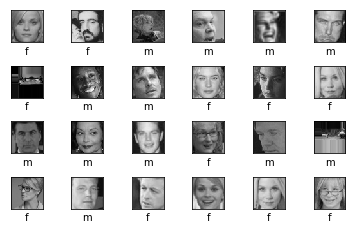

In [10]:
#first 10 images from the test_set
images = test_data.images[:24]

#True classes for images
cls_true = test_data.labels[:24]

# [0, 1] corresponds to femaleness, [male = 0, female] and [1, 0] maleness, [male, female=0] 
plot_images(images = images, cls_true = cls_true)
plt.show()

## Run Tensorflow

In [11]:
session = tf.Session()
x = tf.placeholder(tf.float32, shape=[None, img_size,img_size,num_channels], name='x')

## labels
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)


In [12]:
## Network graph params
filter_size_conv1 = 3 
num_filters_conv1 = 16

filter_size_conv2 = 3
num_filters_conv2 = 32

filter_size_conv3 = 3
num_filters_conv3 = 64
    
fc_layer_size = 128

## model variables to be optimized

In [13]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))


## Convolutional networks

In [14]:
def new_convolutional_layer(input,              # The previous layer
                            num_input_channels, # Num Channels in prev layer
                            conv_filter_size,   # Width and height of each filter
                            num_filters,        # Number of filters
                            use_pooling=True):  # Use 2x2 max-pooling):  
    
    # Shape the filter weights 4conv. 
    shape = [conv_filter_size, conv_filter_size, num_input_channels, num_filters]
    
    #create new weights
    weights = new_weights(shape=shape)
    
    #create new biases
    biases = new_biases(length = num_filters)

    # Tensorflow operation for convolution
    # The first and last strides must always set to 1, bc are for image-number and input-channel respectively, 
    # but here I set the strides all 1
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add bias to the results of the convolution, to each filter channel
    layer += biases

    # Use filter to down sample the image resolution
    if use_pooling:
        # 2x2 max pooling
        layer = tf.nn.max_pool(value=layer, 
                               ksize=[1, 2, 2, 1], 
                               strides=[1, 2, 2, 1], 
                               padding='SAME')
        
    # ReLU activation fun, calculates max(x, 0) for each input channel x, => adds some linearity.     
    layer = tf.nn.relu(layer)
    
    # Note ReLU normally excuted before pooling but, relu(max_pool(x) == max_pool(relu(x)))

#     return layer, weights
    return layer

## Helper Functions for flattening a layer

In [15]:
def flatten_layer(layer):
    # Get shape of input layer from previous layer
    layer_shape = layer.get_shape()
    
    #expected 2be layer_shape == [num_images, img_width, img_height, num_channels] num_images = batch_size
    
    # num_features is img_width * img_height * num_channels
    # Shape uses tensorflow datatype, so convert it to numpy
    num_features = np.array(layer_shape[1:4], dtype=int).prod()
    # num_features = layer_shape[1:4].num_elements()
        
    # Reshape the layer to [num_images, num_features]
    # The first dim is set to -1 wh means the size in that dimension is calculated, so z total size of tensor
    # is unchanged from the reshaping
    layer_flat = tf.reshape(layer, [-1, num_features])
    
#     return layer_flat, num_features
    return layer_flat


## Helper Functions for creating fully connected layers

In [16]:
def create_fc_layer(input,    # The previous layer
                 num_inputs,    # num inputs from the prev layer
                 num_outputs,     # num outputs
                 use_relu = True):  # Use relu?
    
    #Define trainable weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(num_outputs)

    # Fully connected layer takes input x and produces wx+b.Since, these are matrices, we use matmul function in Tensorflow
    layer = tf.matmul(input, weights) + biases
    
    # Use relu:
    if use_relu:
        layer = tf.nn.relu(layer)
        
    return layer

In [17]:
layer_conv1 = new_convolutional_layer(input=x,
                                         num_input_channels=num_channels,
                                         conv_filter_size=filter_size_conv1,
                                         num_filters=num_filters_conv1)

Check layer shape be (?, 32, 132, 16) which means that there is an arbitrary number of
images (this is the ?), each image is 32 pixels wide and 32 pixels high, and there are 16 different channels, one channel for each of the filte

In [18]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 25, 25, 16) dtype=float32>

In [19]:
layer_conv2 = new_convolutional_layer(input=layer_conv1,
               num_input_channels=num_filters_conv1,
               conv_filter_size=filter_size_conv2,
               num_filters=num_filters_conv2)

layer_conv3= new_convolutional_layer(input=layer_conv2,
               num_input_channels=num_filters_conv2,
               conv_filter_size=filter_size_conv3,
               num_filters=num_filters_conv3)

In [20]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 13, 13, 32) dtype=float32>

In [21]:
layer_conv3

<tf.Tensor 'Relu_2:0' shape=(?, 7, 7, 64) dtype=float32>

In [22]:
layer_flat = flatten_layer(layer_conv3)

In [23]:
layer_flat

<tf.Tensor 'Reshape:0' shape=(?, 3136) dtype=float32>

In [24]:
layer_fc1 = create_fc_layer(input=layer_flat,
                     num_inputs=layer_flat.get_shape()[1:4].num_elements(),
                     num_outputs=fc_layer_size,
                     use_relu=True)

layer_fc2 = create_fc_layer(input=layer_fc1,
                     num_inputs=fc_layer_size,
                     num_outputs=num_classes,
                     use_relu=False) 

In [25]:
layer_fc1

<tf.Tensor 'Relu_3:0' shape=(?, 128) dtype=float32>

In [26]:
layer_fc2

<tf.Tensor 'add_4:0' shape=(?, 2) dtype=float32>

In [27]:
y_pred = tf.nn.softmax(layer_fc2,name='y_pred')

y_pred_cls = tf.argmax(y_pred, axis=1)

session.run(tf.global_variables_initializer())


## Cost Functions to be optimized

In [28]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                           labels=y_true)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## Performance measure

In [29]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session.run(tf.global_variables_initializer()) 

In [30]:
def show_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Training Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%},  Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))


## Perform optimization

In [61]:
# Counter for total number of iterations performed so far.
total_iterations = 0

saver = tf.train.Saver()

def train(num_iteration):
    global total_iterations
    
    for i in range(total_iterations, total_iterations + num_iteration):

        x_batch, y_true_batch = train_data.next_batch(batch_size)
        x_valid_batch, y_valid_batch = valid_data.next_batch(batch_size)

        
        feed_dict_tr = {x: x_batch,
                        y_true: y_true_batch
                       }
        
        feed_dict_val = {x: x_valid_batch,
                         y_true: y_valid_batch
                        }

        session.run(optimizer, feed_dict=feed_dict_tr)

        if i % int(train_data.num_examples/batch_size) == 0: 
            val_loss = session.run(cost, feed_dict=feed_dict_val)
            epoch = int(i / int(train_data.num_examples/batch_size))    
            
            show_progress(epoch, feed_dict_tr, feed_dict_val, val_loss)
#             saver.save(session, 'female-male-model') 

        total_iterations += num_iteration

### See the training accuracy
train(num_iteration=1)

train(num_iteration=99)

train(num_iteration=900)

train(num_iteration=10000)

In [53]:
train(num_iteration = 1)

Training Epoch 1 --- Training Accuracy:  65.6%, Validation Accuracy:  62.5%,  Validation Loss: 0.609


In [56]:
train(num_iteration=99)

Training Epoch 1 --- Training Accuracy:  71.9%, Validation Accuracy:  56.2%,  Validation Loss: 0.635


In [58]:
train(num_iteration=900)

Training Epoch 1 --- Training Accuracy:  62.5%, Validation Accuracy:  59.4%,  Validation Loss: 0.672
Training Epoch 2 --- Training Accuracy:  78.1%, Validation Accuracy:  75.0%,  Validation Loss: 0.596


In [60]:
train(num_iteration=9000)

Training Epoch 1 --- Training Accuracy:  68.8%, Validation Accuracy:  53.1%,  Validation Loss: 0.756
Training Epoch 2 --- Training Accuracy:  71.9%, Validation Accuracy:  59.4%,  Validation Loss: 0.651
Training Epoch 3 --- Training Accuracy:  75.0%, Validation Accuracy:  71.9%,  Validation Loss: 0.582
Training Epoch 4 --- Training Accuracy:  75.0%, Validation Accuracy:  68.8%,  Validation Loss: 0.603
Training Epoch 5 --- Training Accuracy:  75.0%, Validation Accuracy:  62.5%,  Validation Loss: 0.640
Training Epoch 6 --- Training Accuracy:  75.0%, Validation Accuracy:  71.9%,  Validation Loss: 0.655
Training Epoch 7 --- Training Accuracy:  75.0%, Validation Accuracy:  81.2%,  Validation Loss: 0.575
Training Epoch 8 --- Training Accuracy:  75.0%, Validation Accuracy:  68.8%,  Validation Loss: 0.660
Training Epoch 9 --- Training Accuracy:  75.0%, Validation Accuracy:  75.0%,  Validation Loss: 0.529
Training Epoch 10 --- Training Accuracy:  75.0%, Validation Accuracy:  65.6%,  Validation L

In [62]:
train(num_iteration=12000)

Training Epoch 1 --- Training Accuracy:  78.1%, Validation Accuracy:  62.5%,  Validation Loss: 0.739
Training Epoch 2 --- Training Accuracy:  78.1%, Validation Accuracy:  78.1%,  Validation Loss: 0.529
Training Epoch 3 --- Training Accuracy:  78.1%, Validation Accuracy:  65.6%,  Validation Loss: 0.550
Training Epoch 4 --- Training Accuracy:  78.1%, Validation Accuracy:  53.1%,  Validation Loss: 0.677
Training Epoch 5 --- Training Accuracy:  81.2%, Validation Accuracy:  78.1%,  Validation Loss: 0.522
Training Epoch 6 --- Training Accuracy:  81.2%, Validation Accuracy:  62.5%,  Validation Loss: 0.610
Training Epoch 7 --- Training Accuracy:  84.4%, Validation Accuracy:  68.8%,  Validation Loss: 0.520
Training Epoch 8 --- Training Accuracy:  84.4%, Validation Accuracy:  78.1%,  Validation Loss: 0.483
Training Epoch 9 --- Training Accuracy:  84.4%, Validation Accuracy:  75.0%,  Validation Loss: 0.485
Training Epoch 10 --- Training Accuracy:  84.4%, Validation Accuracy:  71.9%,  Validation L